# Implementing Convolutional Neural Network from Scratch.
**Data-Set Digit Recognizer from Kaggle = https://www.kaggle.com/c/digit-recognizer/data ** <br>
**Digits 0-9**

### Import the Required Libraries

In [21]:
import pandas as pd              #for data manipulation
import numpy as np               #for maths
import matplotlib.pyplot as plt  #for visualization
%matplotlib inline

### Get the Training Data

In [2]:
#path to data
path = r'E:\Study n Work\Machine Learning\Kaggle\Digit Recognizer\Data\train.csv'

#read data
train_data = pd.read_csv(path)

In [3]:
#lets see the data
train_data.head(3)       

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
shape = train_data.shape  #get shape
m = shape[0]              #number of images 
num_pix = shape[1]-1      #number of pixels, First Col is Label of Image so '-1'
labels = np.unique(train_data['label'])

print("Shape of Dataset {}".format(shape))
print("Number of Images {}".format(m))
print("Number of pixels {}".format(num_pix))
print("Unique Labels    {}".format(labels))

Shape of Dataset (42000, 785)
Number of Images 42000
Number of pixels 784
Unique Labels    [0 1 2 3 4 5 6 7 8 9]


### Separating Features and Labels from the dataset.

In [5]:
#Labels
train_labels = np.array(train_data['label']).reshape(train_data.shape[0],1)
print("Shape of Labels   = {}".format(train_labels.shape))

#Features
train_dataset = np.array(train_data.iloc[:,1:785]).reshape(train_data.shape[0],784)
print("Shape of Features = {}".format(train_dataset.shape))

Shape of Labels   = (42000, 1)
Shape of Features = (42000, 784)


### Lets see some images

Labels :  [7]   [5]   [1]   [9]   [0]   

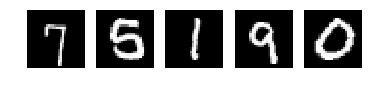

In [30]:
images = np.array(train_dataset[50:55,:]).reshape(5,28,28,1)   #convert it into 28*28*1
labs = np.array(train_labels[50:55]).reshape(5,1)

fig = plt.figure()
print("Labels : ",end= ' ')
for i in range(5):
    fig.add_subplot(1,5,i+1)
    plt.imshow(images[i,:,:,0],cmap='gray')
    print("{}  ".format(labs[i]),end=" ")
    plt.axis("off")
    

### Normalize the dataset and Break the dataset into Test, Valid, Train dataset

**Normalize :**
image_data = (image_data-127)/255

**Data Distribution**
1. Train Dataset - 70%
2. Valid Dataset - 15%
3. Test  Dataset - 15%



In [7]:
#Normalizing the dataset
train_dataset = (train_dataset-127)/255

In [8]:
#Breaking the dataset into test dataset, valid dataset and train dataset.

test_dataset = np.array(train_dataset[36000:42000]).reshape(-1,num_pix)
test_labels = np.array(train_labels[36000:42000]).reshape(-1,1)

valid_dataset = np.array(train_dataset[30000:36000]).reshape(-1,num_pix)
valid_labels = np.array(train_labels[30000:36000]).reshape(-1,1)

train_dataset = np.array(train_dataset[0:30000]).reshape(-1,num_pix)
train_labels = np.array(train_labels[0:30000]).reshape(-1,1)

print("Train dataset = {}".format(train_dataset.shape,train_labels.shape))
print("Valid dataset = {}".format(valid_dataset.shape,valid_labels.shape))
print("Test dataset  = {}".format(test_dataset.shape,test_labels.shape))

Train dataset = (30000, 784)
Valid dataset = (6000, 784)
Test dataset  = (6000, 784)


### One Hot Encoding

**Example : If label = 4 : [0,0,0,0,1,0,0,0,0,0]**

In [9]:
neural_train_labels = np.zeros((train_labels.shape[0],10))
neural_valid_labels = np.zeros((valid_labels.shape[0],10))
neural_test_labels = np.zeros((test_labels.shape[0],10))

for i,value in enumerate(train_labels):
    neural_train_labels[i,value] = 1

for i,value in enumerate(valid_labels):
    neural_valid_labels[i,value] = 1

for i,value in enumerate(test_labels):
    neural_test_labels[i,value] = 1

print("Train labels = {}".format(neural_train_labels.shape))
print("Valid labels = {}".format(neural_valid_labels.shape))
print("Test labels  = {}".format(neural_test_labels.shape))

Train labels = (30000, 10)
Valid labels = (6000, 10)
Test labels  = (6000, 10)


### Reformatting the dataset
**Example : pixels = 784 , convert them into [28,28,1]**

In [10]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

def reformat(dataset):
    dataset = dataset.reshape(-1,image_size,image_size,num_channels).astype(np.float32)
    return dataset

train_dataset = reformat(train_dataset)
valid_dataset = reformat(valid_dataset)
test_dataset = reformat(test_dataset)

print('Training set   = {}'.format(train_dataset.shape, neural_train_labels.shape))
print('Validation set = {}'.format(valid_dataset.shape, neural_valid_labels.shape))
print('Test set       = {}'.format(test_dataset.shape, neural_test_labels.shape))

Training set   = (30000, 28, 28, 1)
Validation set = (6000, 28, 28, 1)
Test set       = (6000, 28, 28, 1)


### Hyperparameters

In [11]:
#pixels
image_size = 28

#greyscale
num_channels = 1

#patch size
patch_size = 3

#depth
depth = 4

#hidden layers
hidden1 = 256

#hyperparameters
learning_rate = 0.1

#regularization
beta = 0

#target_labels
num_classes = 10

### Activation Functions
**In-Between Layers** <br>
* **Sigmoid = 1 / (1+exp(-X))** 

**For Final Layer**
* **Softmax = exp(X) / (sum(exp(X),1))**

In [32]:
#sigmoid
def sigmoid(X):
    return 1/(1+np.exp(-1*X))

#softmax
def softmax(X):
    exp_X = np.exp(X)
    sum_exp_X = np.sum(exp_X,1).reshape(-1,1)  #col-wise sum
    exp_X = exp_X/sum_exp_X
    return exp_X

### Initialize Weights
* ** conv_layer1_weights = [3,3,1,4] **<br>
* ** conv_layer2_weights = [3,3,4,16]**<br>
* ** full_layer1_weights = [504,256] **<br>
* ** full_layer2_weights = [256,10]  **<br>

Store these weights in parameters dictionary!

In [12]:
 def initialize_parameters():
    #initialize weights values with 0 mean and 0.5 standard deviation.
    mean = 0
    std = 0.5
    
    #conv layer weights
    conv_layer1_weights = np.random.normal(mean,std,(patch_size,patch_size,num_channels,depth))
    conv_layer1_biases = np.zeros([1,depth])
    conv_layer2_weights = np.random.normal(mean,std,(patch_size,patch_size,depth,depth*4))
    conv_layer2_biases = np.zeros([1,depth*4])
    
    #fully-connected weights
    full_layer1_weights = np.random.normal(mean,std,(((image_size//4-1) * (image_size//4-1) * depth * 4),hidden1))
    full_layer1_biases = np.zeros([hidden1])
    full_layer2_weights = np.random.normal(mean,std,(hidden1,num_classes))
    full_layer2_biases = np.zeros([num_classes])
    
    parameters = dict()
    parameters['cw1'] = conv_layer1_weights
    parameters['cb1'] = conv_layer1_biases
    parameters['cw2'] = conv_layer2_weights
    parameters['cb2'] = conv_layer2_biases
    parameters['fw1'] = full_layer1_weights
    parameters['fb1'] = full_layer1_biases
    parameters['fw2'] = full_layer2_weights
    parameters['fb2'] = full_layer2_biases
    
    return parameters

### Convolution Operation
![](https://github.com/navjindervirdee/neural-networks/blob/master/Convolutional%20Neural%20Network/Convolution.PNG?raw=true>)

![]( "https://github.com/navjindervirdee/neural-networks/blob/master/Convolutional%20Neural%20Network/Convolution.PNG?raw=true" )


* **Red   Cell : 5x1 + 4x2 + 3x1 + 6x3 + 2x1 + 1x0 + 5x2 + 7x3 + 3x1 = 70**
* **Green Cell : 4x1 + 3x2 + 1x1 + 2x3 + 1x1 + 4x0 + 7x2 + 3x3 + 2x1 = 43**
* **Blue  Cell : 6x1 + 2x2 + 1x1 + 5x3 + 7x1 + 3x0 + 1x2 + 4x3 + 2x1 = 49**
* **Purp  Cell : 2x1 + 1x2 + 4x1 + 7x3 + 3x1 + 2x0 + 4x2 + 2x3 + 3x1 = 49**

In the function below Hardcoded : <br>
Stride = 2 <br>
Padding = 0

In [13]:
#Convolution operation i.e multiplying Image with the weights.
#stride hardcoded = 2
#padding  = 0
def conv_multiply(image,weights):
    hsize = (image.shape[0]-weights.shape[0])//2 + 1
    vsize = (image.shape[1]-weights.shape[1])//2 + 1
    logits = np.zeros([hsize,vsize,weights.shape[3]])
    for d in range(weights.shape[3]):
        row = 0
        for rpos in range(0,(image.shape[0]-patch_size+1),2):
            col=0
            for cpos in range(0,(image.shape[1]-patch_size+1),2):
                logits[row,col,d] = np.sum(np.multiply(image[rpos:rpos+patch_size, cpos:cpos+patch_size, :],weights[:,:,:,d]))
                col += 1
            row+=1
    return logits

### Forward Propagation
![](https://github.com/navjindervirdee/neural-networks/blob/master/Convolutional%20Neural%20Network/Forward.JPG?raw=true)

* Function returns the intermediate activations in **cache dictionary** and final output in output

In [14]:
#FORWARD PROPAGATION
def forward_propagation(dataset,parameters):
    #convolution layers activations
    m = dataset.shape[0]
    
    #get the parameters
    cw1 = parameters['cw1']
    cb1 = parameters['cb1']
    cw2 = parameters['cw2']
    cb2 = parameters['cb2']
    
    fw1 = parameters['fw1']
    fb1 = parameters['fb1']
    fw2 = parameters['fw2']
    fb2 = parameters['fb2']
    
    #to store the intermediate activations for backward propagation
    cache = dict()
    
    conv_activation1 = list()
    conv_activation2 = list()
    
    #image by image convolutional forward propagation
    for i in range(m):
        image = dataset[i]
        logits = conv_multiply(image,cw1) + cb1
        ca1 = sigmoid(logits)
        ca2 = sigmoid(conv_multiply(ca1,cw2) + cb2).reshape((image_size // 4 -1) * (image_size // 4 -1) * depth * 4)
        
        conv_activation1.append(ca1)
        conv_activation2.append(ca2)
        
    #convert into numpy array
    conv_activation1 = np.array(conv_activation1).reshape(m,image_size // 2 -1, image_size // 2 -1, depth)
    conv_activation2 = np.array(conv_activation2).reshape(m,image_size // 4 -1, image_size // 4 -1, depth * 4)
        
    #expand the conv_activation2 into (m,num_features) 
    #num_features = (image_size // 4 * image_size // 4 * depth * 4)
    temp_activation = np.array(conv_activation2).reshape(m,(image_size // 4 -1) * (image_size // 4-1) * depth * 4)
    
    #fully connected layers activations
    full_activation1 = np.matmul(temp_activation,fw1) + fb1
    full_activation1 = sigmoid(full_activation1)
    full_activation2 = np.matmul(full_activation1,fw2) + fb2
    output = softmax(full_activation2)
    
    cache['ca1'] = conv_activation1
    cache['ca2'] = conv_activation2
    cache['fa1'] = full_activation1
    cache['output'] = output
    return cache,output

### Backward Propagation
* Apply the Chain Rule and calculate the derivatives.
* Returns the derivatives in ** derivatives dictionary **

#### Calculate Error terms for Conv Layers

In [15]:
#calculate conv deltas or errors only for one example
def conv_delta(next_error,weights):
    delta = np.zeros([next_error.shape[0]*2+1,next_error.shape[1]*2+1,next_error.shape[2]//4])
    for d in range(weights.shape[3]):
        row = 0
        for rpos in range(0,delta.shape[0]-patch_size+1,2):
            col=0
            for cpos in range(0,delta.shape[2]-patch_size+1,2):
                delta[rpos:rpos+patch_size,cpos:cpos+patch_size,:] += weights[:,:,:,d]*next_error[row,col,d]
                col+=1
            row +=1
    return delta

#### Calculate the derivatives for Conv layer Weights

In [16]:
#conv partial derivatives only for single example
def conv_derivatives(delta,activation):
    partial_derivatives = np.zeros([patch_size,patch_size,activation.shape[2],delta.shape[2]])
    for d2 in range(0,partial_derivatives.shape[3]):
        row=0
        for rpos in range(0,activation.shape[0]-patch_size+1,2):
            col = 0
            for cpos in range(0,activation.shape[1]-patch_size+1,2):
                partial_derivatives[:,:,:,d2] += np.multiply(activation[rpos:rpos+patch_size, cpos:cpos+patch_size, :],delta[row,col,d2])
                col += 1
            row += 1
    return partial_derivatives

#### Full Backward Propagation

In [17]:
def backward_propagation(dataset,labels,cache,parameters):
    #get activations
    output = cache['output']
    fa1 = cache['fa1']
    ca2 = cache['ca2']
    ca1 = cache['ca1']
    
    temp_act = np.array(ca2).reshape(-1,(image_size // 4-1) * (image_size // 4 -1)* depth * 4)
    
    #get parameters
    cw1 = parameters['cw1']
    cw2 = parameters['cw2']
    fw1 = parameters['fw1']
    fw2 = parameters['fw2']
    
    
    #cal errors fully connected
    error_fa2 = output - labels
    error_fa1 = np.matmul(error_fa2,fw2.T)
    error_fa1 = np.multiply(error_fa1,fa1)
    error_fa1 = np.multiply(error_fa1,(1-fa1))
    error_temp = np.matmul(error_fa1,fw1.T)
    error_temp = np.multiply(error_temp,temp_act)
    error_temp = np.multiply(error_temp,(1-temp_act))
    
    m = dataset.shape[0]
    
    #cal errors conv layers
    error_ca2 = np.array(error_temp).reshape(-1,image_size//4-1,image_size//4-1,depth*4)
    error_ca1 = np.zeros(ca1.shape)
    ## Image by Image error
    for i in range(m):
        error = conv_delta(error_ca2[i],cw2)
        error = np.multiply(error,ca1[i])
        error = np.multiply(error,(1-ca1[i]))
        error_ca1 += error
    
    
    #calculate partial derivatives
    #fully connected layers
    fd2 = (np.matmul(fa1.T,error_fa2) + beta*fw2)/m
    fd1 = (np.matmul(temp_act.T,error_fa1) + beta*fw1)/m
    
    #conv layers
    cd2 = np.zeros(cw2.shape)
    cd1 = np.zeros(cw1.shape)
    
    ##Image by Image derivatives
    for i in range(m):
        cd2 = cd2 + conv_derivatives(error_ca2[i],ca1[i])
        cd1 = cd1 + conv_derivatives(error_ca1[i],dataset[i])
    cd2 = (cd2 + beta*cw2)/m
    cd1 = (cd1 + beta*cw1)/m
    
    
    #store the derivatives in dict
    derivatives = dict()
    
    derivatives['cd1'] = cd1
    derivatives['cd2'] = cd2
    derivatives['fd1'] = fd1
    derivatives['fd2'] = fd2
    
    return derivatives

### Update Parameters

In [18]:
def update_parameters(derivatives,parameters):
    #get parameters
    cw1 = parameters['cw1']
    cw2 = parameters['cw2']
    fw1 = parameters['fw1']
    fw2 = parameters['fw2']
    
    #get derivatives
    cd1 = derivatives['cd1']
    cd2 = derivatives['cd2']
    fd1 = derivatives['fd1']
    fd2 = derivatives['fd2']
    
    #update
    cw1 = cw1 - learning_rate*cd1
    cw2 = cw2 - learning_rate*cd2
    fw1 = fw1 - learning_rate*fd1
    fw2 = fw2 - learning_rate*fd2
    
    #update the dict
    parameters['cw1'] = cw1
    parameters['cw2'] = cw2
    parameters['fw1'] = fw1
    parameters['fw2'] = fw2
    
    return parameters

### Loss and Accuracy
* Loss = -sum((Y x log(predictions) + (1-Y) x (log(1-predictions))))/m + (beta x (sum(cw1^2) + sum(cw2^2) + sum(fw1^2) + sum(fw2^2)))
* Accuray = sum(Y==Predictions)/m <br>

m = number of examples

In [19]:
def cal_loss_accuracy(true_labels,predictions,parameters):
    #get parameters
    cw1 = parameters['cw1']
    cw2 = parameters['cw2']
    fw1 = parameters['fw1']
    fw2 = parameters['fw2']
    
    m = len(true_labels)
    
    #cal loss
    loss = -1*(np.sum(np.multiply(np.log(predictions),true_labels),1) + np.sum(np.multiply(np.log(1-predictions),1-true_labels),1))
    loss = np.sum(loss)
    loss = loss + beta*(np.sum(cw1**2) + np.sum(cw2**2) + np.sum(fw1**2) + np.sum(fw2**2))
    loss = loss/m
    
    #cal accuracy
    accuracy = np.sum(np.argmax(true_labels,1)==np.argmax(predictions,1))/m
    
    return loss,accuracy

### Train Function

1. Initialize the parameters
2. Forward Propagation
3. Calculate Loss and Accuracy
4. Backward Propagation
5. Update the Parameters 

Batch Size = 20 <br>
Repeat the steps 2-5 for every Batch

In [20]:
#train function
def train(train_dataset,train_labels,batch_size=20,iters=101,stride=2):
    
    #initialize the parameters
    parameters = initialize_parameters()
    
    cw1 = parameters['cw1']
    cb1 = parameters['cb1']
    cw2 = parameters['cw2']
    cb2 = parameters['cb2']
    
    fw1 = parameters['fw1']
    fb1 = parameters['fb1']
    fw2 = parameters['fw2']
    fb2 = parameters['fb2']
    
    J = []  #store the loss o every batch
    A = []  #store the accuracy of every batch
    
    
    #training process.
    for step in range(iters):
        #get the batch data.
        start = (step*batch_size)%(train_dataset.shape[0])
        end = start + batch_size
        
        batch_dataset = train_dataset[start:end,:,:,:]
        batch_labels = train_labels[start:end,:]
        
        #forward propagation
        cache,output = forward_propagation(batch_dataset,parameters)
        
        #cal_loss and accuracy
        loss,accuracy = cal_loss_accuracy(batch_labels,output,parameters)
        
        #calculate the derivatives
        derivatives = backward_propagation(batch_dataset,batch_labels,cache,parameters)
        
        #update the parameters
        parameters = update_parameters(derivatives,parameters)
        
        #append the loss and accuracy of every batch
        J.append(loss)
        A.append(accuracy)
        
        #print loss and accuracy of the batch dataset.
        if(step%100==0):
            print('Step : %d'%step)
            print('Loss : %f'%loss)
            print('Accuracy : %f%%'%(round(accuracy*100,2)))
            
    return J,A,parameters

###  Let's Train

* 1501 Iterations is equivalent to ony one pass of entire training set (20*1500==30000).i.e an image is seen only once.
* Takes 15-20 mins for 1501 iterations on CPU

In [33]:
#TRAINING
J,A,parameters = train(train_dataset,neural_train_labels,iters=1501)

Step : 0
Loss : 29.588228
Accuracy : 5.000000%
Step : 100
Loss : 3.916968
Accuracy : 20.000000%
Step : 200
Loss : 1.254349
Accuracy : 70.000000%
Step : 300
Loss : 1.120634
Accuracy : 80.000000%
Step : 400
Loss : 0.926653
Accuracy : 85.000000%
Step : 500
Loss : 1.102221
Accuracy : 75.000000%
Step : 600
Loss : 1.095985
Accuracy : 85.000000%
Step : 700
Loss : 0.311776
Accuracy : 100.000000%
Step : 800
Loss : 0.874659
Accuracy : 85.000000%
Step : 900
Loss : 0.298078
Accuracy : 95.000000%
Step : 1000
Loss : 0.442242
Accuracy : 95.000000%
Step : 1100
Loss : 0.881340
Accuracy : 80.000000%
Step : 1200
Loss : 0.437191
Accuracy : 90.000000%
Step : 1300
Loss : 0.764755
Accuracy : 85.000000%
Step : 1400
Loss : 0.920038
Accuracy : 75.000000%
Step : 1500
Loss : 0.678187
Accuracy : 80.000000%


** The above accuracy and loss are of random batch data of size = 20, and not of entire training set **

### Let's Calculate the accuracy of entire Training Set, Valid Set and Test Set
* Will take around 25-30 mins on CPU!

In [49]:
#for training set
_,train_pred = forward_propagation(train_dataset,parameters)
_,train_accuracy = cal_loss_accuracy(neural_train_labels,train_pred,parameters)

#for valid set
_,valid_pred = forward_propagation(valid_dataset,parameters)
_,valid_accuracy = cal_loss_accuracy(neural_valid_labels,valid_pred,parameters)

#for test set
_,test_pred = forward_propagation(test_dataset,parameters)
_,test_accuracy = cal_loss_accuracy(neural_test_labels,test_pred,parameters)

In [50]:
#print
print('Accuracy of Train Set = {}'.format(round(train_accuracy*100,2)))
print('Accuracy of Valid Set = {}'.format(round(valid_accuracy*100,2)))
print('Accuracy of Test  Set = {}'.format(round(test_accuracy*100,2)))

Accuracy of Train Set = 87.94
Accuracy of Valid Set = 87.77
Accuracy of Test  Set = 87.88


** So we have achieved an accuracy of 87% for all three datasets. Pretty Good!**

### Let's Plot some graphs

*  Plotted average loss of 30 batches and average accuracy of 30 batches.

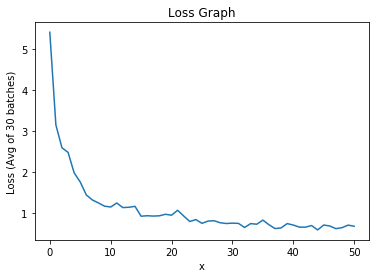

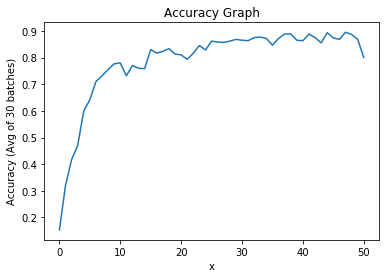

In [106]:
avg_loss = list()
avg_acc = list()
i = 0
while(i<len(J)):
    avg_loss.append(np.mean(J[i:i+30]))
    avg_acc.append(np.mean(A[i:i+30]))
    i += 30

plt.plot(list(range(len(avg_loss))),avg_loss)
plt.xlabel("x")
plt.ylabel("Loss (Avg of 30 batches)")
plt.title("Loss Graph")
plt.show()

plt.plot(list(range(len(avg_acc))),avg_acc)
plt.xlabel("x")
plt.ylabel("Accuracy (Avg of 30 batches)")
plt.title("Accuracy Graph")
plt.show()    

### Let's  visualize what the intermediate conv layers are learning!

Image


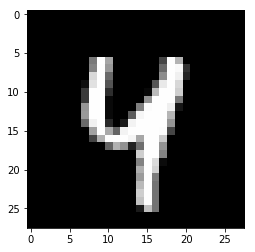

True_Label = 4
Pred_Label = 4


In [75]:
index = 10
test_image = test_dataset[index].reshape(1,28,28,1)
plt.imshow(test_image[0,:,:,0],cmap='gray')
print("Image")
plt.show()
print("True_Label = {}".format(np.argmax(neural_test_labels[index])))
print("Pred_Label = {}".format(np.argmax(test_pred[index])))

In [76]:
cache,pred = forward_propagation(test_image,parameters)

In [77]:
conv_layer1 = cache['ca1']
conv_layer2 = cache['ca2']

Conv layer1 Activations


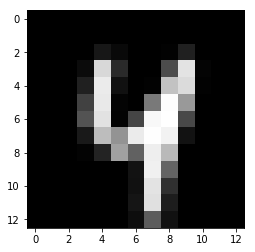

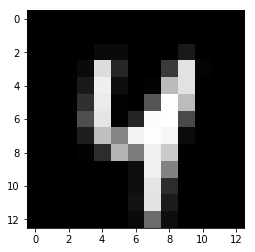

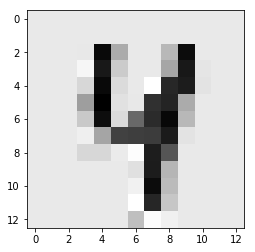

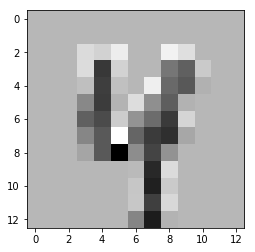

Conv layer2 Activations


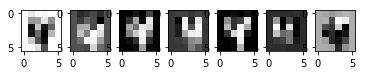

In [88]:
print("Conv layer1 Activations")
for i in range(conv_layer1.shape[3]):
    plt.imshow(conv_layer1[0,:,:,i],cmap='gray')
    plt.show()

fig2 = plt.figure()
print("Conv layer2 Activations")
for i in range(0,(conv_layer2.shape[3]-9)):
    fig2.add_subplot(1,7,i+1)
    plt.imshow(conv_layer2[0,:,:,i],cmap='gray')
    

### Some Predictions made by the MODEL  

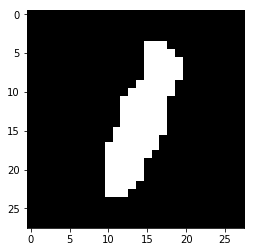

Predicted Label = 1


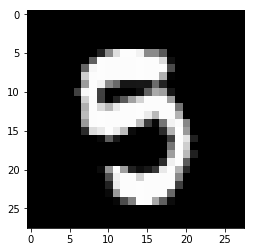

Predicted Label = 5


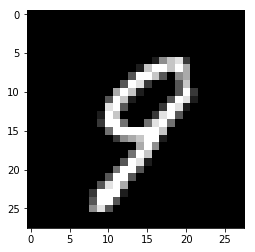

Predicted Label = 9


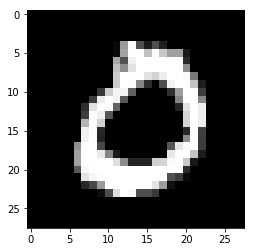

Predicted Label = 0


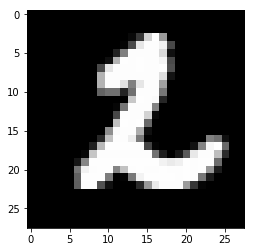

Predicted Label = 2


In [93]:
images = test_dataset[0:5]
image_labels = neural_test_labels[0:5]

for i in range(len(images)):
    plt.imshow(images[i,:,:,0],cmap='gray')
    plt.show()
    print("Predicted Label = {}".format(np.argmax(image_labels[i])))

# THE END